In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:

pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))

In [10]:
#migration
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers', 'outmigrationrate','netmigration','number_of_outmigrations']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=data.copy()
df=df[df['Mention_country'].isin(possible_iso)]



# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "padded_population_of_researchers": 0,
                "incomelevel": country_data["incomelevel"].iloc[0] if not country_data.empty else np.nan,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)

df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['netmigration'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)


columns_to_fill=['incomelevel', 'gdp_per_capita', 'population', 'region',
       'padded_population_of_researchers', 'outmigrationrate',
       'netmigration', 'number_of_outmigrations',]
df_complete[columns_to_fill] = df_complete.groupby('Mention_country')[columns_to_fill].ffill()
df_complete[columns_to_fill] = df_complete.groupby('Mention_country')[columns_to_fill].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)

c:\Users\Yasaman\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yasaman\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log Domestic attention')

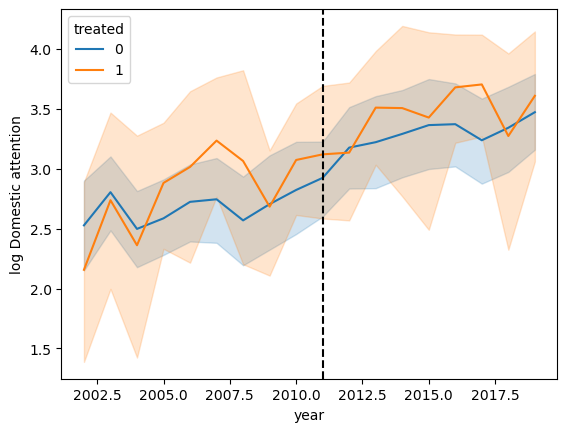

In [11]:
sns.lineplot(data=df_complete, x='year', y='log_count', hue='treated')
plt.axvline(2011, color='k', linestyle='--')
plt.ylabel('log Domestic attention')

Text(0, 0.5, 'Net migration rate')

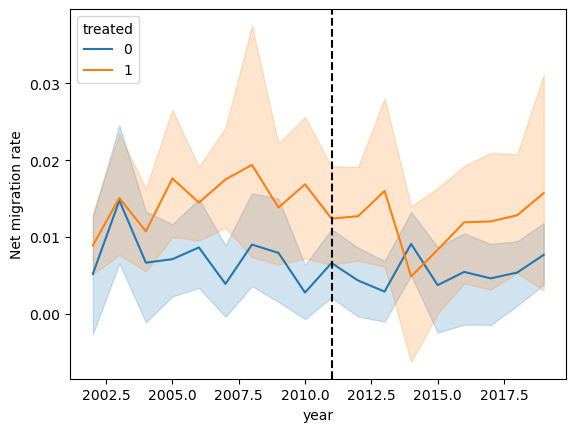

In [5]:
sns.lineplot(data=df_complete, x='year', y='netmigrationrate', hue='treated')
plt.axvline(2011, color='k', linestyle='--')
plt.ylabel('Net migration rate')